# Experiment Data Plotting

## 0. Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
import scqubits as scq
import ezfit as ez
import abcd_rf_fit as abcd
import scipy as sp

In [3]:
def IQ_rotate(y, return_angle = False):
    """Rotates complex IQ data to be aligned along the real axis?
    Adapted from ezfit
    """
    y_return = y
    y = y.flatten()

    if not np.any(np.iscomplex(y)):
        # print('Did not rotate: no complex data')
        return

    # remove nan's and infinites
    # x = x[np.isfinite(y)]
    # y = y[np.isfinite(y)]

    v_poly_1 = np.polyfit(y.real, y.imag, 1)
    v_poly_2 = np.polyfit(y.imag, y.real, 1)
    # get slope from smallest value of dy/dx and dx/dy
    if abs(v_poly_1[0]) < abs(v_poly_2[0]):
        angle = np.arctan(v_poly_1[0])
    else:
        angle = np.pi / 2.0 - np.arctan(v_poly_2[0])
        if angle > np.pi:
            angle -= np.pi
    angle = -angle
    # try to make features appear as peaks instead of dips by adding pi
    data = np.real(y * np.exp(1j * angle))
    mean_value = np.mean(data)
    # get metrics
    first = abs(data[0] - mean_value)
    low = abs(np.min(data) - mean_value)
    high = abs(np.max(data) - mean_value)
    # method: use first point if first signal > 0.5 of max or min
    if first > 0.5 * max(low, high):
        # approach 1: check first point (good for oscillations)
        if data[0] < mean_value:
            angle += np.pi
    else:
        # approach 2: check max/min points
        if high < low:
            angle += np.pi

    # real = np.real(y) * np.cos(angle) - np.imag(y) * np.sin(angle)
    # imag = np.real(y) * np.sin(angle) + np.imag(y) * np.cos(angle)
    if return_angle: 
        return y_return * np.exp(1j * angle), angle
    
    else: 
        return y_return * np.exp(1j * angle)
    
def IQ_rotate_angle(y):
    """Rotates complex IQ data to be aligned along the real axis?
    Adapted from ezfit
    """
    _, angle = IQ_rotate(y, return_angle=True)

    return angle
    
def plot_2D(
    x,
    y,
    z,
    xlabel=None,
    ylabel=None,
    zlabel=None,
    title=None,
    fig=None,
    ax=None,
    return_fig=True,
    vmin=None,
    vmax=None,
    figsize = (6, 4),
    cmap = "Plasma",
):
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, 1, dpi=200, figsize=figsize)
    fig = ax.get_figure()

    X, Y = np.meshgrid(x, y, indexing="ij")

    vmin = z.min() if vmin is None else vmin
    vmax = z.max() if vmax is None else vmax

    c = ax.pcolormesh(
        X, Y, z, cmap=cmap, vmin=vmin, vmax=vmax
    )  # change to pcolorfast for speed
    # ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    cb = fig.colorbar(c, ax=ax)
    cb.set_ticks([0.1, 0.5])
    cb.set_label(zlabel, rotation=270, labelpad=15)
    fig.tight_layout()

    if return_fig:
        return fig, ax

    return cb

In [4]:
def gen_fluxonium(φ):
    Ec = 1.678 # 1.68 GHz
    Ej = 8.987 # 9.056 GHz
    El = 0.342 # GHz
    return scq.Fluxonium(EJ=Ej, EC=Ec, EL=El, flux=φ, cutoff=100, truncated_dim=10)

## Resonator Spectroscopy vs. Flux 

In [ ]:
directory = '/Users/shoumikdc/Dropbox (MIT)/EQuS/People/Shoumik/DataQM/'
filename = '2023/02/Data_0228/res_spec_vs_bobbin_cavityA_flux_dependence_0004.hdf5'
filename2 = '2023/02/Data_0228/res_spec_vs_bobbin_cavityA_flux_dependence_lowpower_0001.hdf5'

file = h5py.File(directory + filename, 'r')
fluxes = np.array(file['data']['bobbin'][::])
freqs = np.array(file['data']['freqs']) / 1e9
s = np.array(file['data']['s'])

file2 = h5py.File(directory + filename2, 'r')
fluxes2 = np.array(file2['data']['bobbin'][::])
freqs2 = np.array(file2['data']['freqs']) / 1e9
s2 = np.array(file2['data']['s'])

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 5), dpi=600, sharex=True)

font = {'size'   : 13}
mpl.rc('font', **font)

im = axs[0].imshow(np.gradient(np.unwrap(np.angle(s)), freqs * 1e3, axis=1).T[::-1], extent=[fluxes[0], fluxes[-1], freqs[0], freqs[-1]], aspect='auto')
axs[0].set_ylim(7.84295, 7.84345)
axs[0].set_yticks([7.8430, 7.8432, 7.8434])

# Minus sign is because the phase is inverted!
im2 = axs[1].imshow(np.gradient(np.unwrap(-np.angle(s2)), freqs2 * 1e3, axis=1).T[::-1], extent=[fluxes2[0], fluxes2[-1], freqs2[0], freqs2[-1]], aspect='auto')
axs[1].set_ylim(7.8436, None)
axs[1].set_yticks([7.8437, 7.8443, 7.8449])
axs[1].set_xlabel("Ext. Flux Bias Voltage (V)", fontsize=15)

ax = fig.add_subplot(111, frameon=False)    # The big subplot
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("Frequency $f$ (GHz)", labelpad=32, fontsize=15)
fig.text(0.92, 0.31, r"Grad. of Phase $\frac{d\theta}{df}$ (deg / MHz)", rotation=-90, fontsize=14)

plt.tight_layout()

cb = plt.colorbar(im, ax=axs[0], pad=0.02)
cb.ax.set_ylim(-160, 10)
cb.ax.set_yticks([-150, -100, -50, 0])
cb.ax.tick_params(labelsize=12)

cb2 = plt.colorbar(im2, ax=axs[1], pad=0.02)
cb2.ax.set_ylim(-11, None)
cb2.ax.tick_params(labelsize=12)

plt.savefig("resonator_spectroscopy_vs_flux.pdf")

## Resonator Spectroscopy vs. Power 

In [ ]:
# Get an example of a single resonator spectroscopy measurement
directory = '/Users/shoumikdc/Dropbox (MIT)/EQuS/People/Shoumik/DataQM/'
filename = '2023/02/Data_0227/res_spec_vs_bobbin_cavityA_flux_dependence_0001.hdf5'

file = h5py.File(directory + filename, 'r')
freqs = np.array(file['data']['freqs']) / 1e9
s = np.array(file['data']['s'])

signal = np.exp(1j * np.pi * 0.7) * s[69, :]

In [ ]:
fig = plt.figure(figsize=(15.25, 4), dpi=600)
# axs = fig.subplot_mosaic([['A', 'C', 'D'],['B', 'C', 'D']],
#                           gridspec_kw={'width_ratios':[1, 2, 2]})

axs = fig.subplot_mosaic([['A', 'C', 'D'],['A', 'C', 'D']],
                          gridspec_kw={'width_ratios':[0.5, 2, 2]})


# =============================================================================

font = {'size'   : 13}
mpl.rc('font', **font)


f_0 = 7.8442
axs['A'].plot(freqs[:120], np.gradient(np.unwrap(np.angle(signal)), freqs * 1e3)[:120], '.-')
res_fit = ez.LorentzianFit(freqs[:120], np.gradient(np.unwrap(np.angle(signal)), freqs * 1e3)[:120]); res_fit.fit()
axs['A'].plot(freqs[:120], res_fit.func(freqs[:120], *res_fit.popt), ls='-', c="tab:blue")



# axs['B'].plot((freqs - f_0) * 1e3, np.angle(signal), 'o')
# axs['A'].sharex(axs['B'])
# axs['A'].tick_params(labelbottom=False)

# axs['A'].tick_params(labelsize=12)
axs['A'].set_xlabel(r"Frequency $f$ (GHz)", fontsize=15)
axs['A'].set_ylabel(r"Grad. of Phase $\frac{d\theta}{df}$ (deg / MHz)", fontsize=15)
axs['A'].set_ylim(None, 8)
# axs['A'].set_xlim(None, 0)
# axs['B'].set_ylabel("Phase")

# =============================================================================
mag = Image.open("res_spec_vs_power_mag.png")
phase = Image.open("res_spec_vs_power_phase.png")

axs['C'].imshow(mag, extent=[0, 1334, 1034, 0])
axs['D'].imshow(phase, extent=[0, 1334, 1034, 0])

tick_x = 1334 / 40
axs['C'].set_xticks([tick_x, 20 * tick_x, 39 * tick_x])
axs['D'].set_xticks([tick_x, 20 * tick_x, 39 * tick_x])
axs['C'].set_xticklabels(np.linspace(-30, -10, 3))
axs['D'].set_xticklabels(np.linspace(-30, -10, 3))


tick_y = 1034
axs['C'].set_yticks([0, tick_y / 2, tick_y])
axs['C'].set_yticklabels([7.846, 7.844, 7.842])
axs['D'].set_yticks([0, tick_y / 2, tick_y])
axs['D'].set_yticklabels([7.846, 7.844, 7.842])

axs['C'].set_xlabel("L.O. Output Power (dBm)", fontsize=15)
axs['D'].set_xlabel("L.O. Output Power (dBm)", fontsize=15)
axs['C'].set_ylabel(r"Frequency $f$ (GHz)", fontsize=15)
axs['D'].set_ylabel(r"Frequency $f$ (GHz)", fontsize=15)

plt.tight_layout()

# Colorbars
sm_mag = plt.cm.ScalarMappable(cmap="plasma", norm=mpl.colors.Normalize(vmin=0.1,vmax=1.5))
sm_phase = plt.cm.ScalarMappable(cmap="plasma", norm=mpl.colors.Normalize(vmin=-5000 * (1e-3),vmax=10000 * (1e-3)))
cb_mag = plt.colorbar(sm_mag, ax=axs['C'])
cb_phase = plt.colorbar(sm_phase, ax=axs['D'])

cb_mag.set_label(label = r"Magnitude (u.n.c)", fontsize = 12, rotation = -90, labelpad = 20)
cb_phase.set_label(label = r"Grad. of Phase $\frac{d\theta}{df}$ (deg / MHz)", fontsize = 12, rotation = -90, labelpad = 20)
plt.savefig("resonator_spectroscopy.pdf")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=600)

axs[0].imshow(mag, extent=[0, 1334, 1034, 0])
axs[1].imshow(phase, extent=[0, 1334, 1034, 0])

tick_x = 1334 / 40
axs[0].set_xticks([tick_x, 20 * tick_x, 39 * tick_x])
axs[1].set_xticks([tick_x, 20 * tick_x, 39 * tick_x])
axs[0].set_xticklabels(np.linspace(-30, -10, 3))
axs[1].set_xticklabels(np.linspace(-30, -10, 3))


tick_y = 1034
axs[0].set_yticks([0, tick_y / 2, tick_y])
axs[0].set_yticklabels([7.846, 7.844, 7.842])
axs[1].set_yticks([0, tick_y / 2, tick_y])
axs[1].set_yticklabels([7.846, 7.844, 7.842])

axs[0].set_xlabel("L.O. Output Power (dBm)", fontsize=15)
axs[1].set_xlabel("L.O. Output Power (dBm)", fontsize=15)
axs[0].set_ylabel(r"Frequency $f_r$ (GHz)", fontsize=15)
axs[1].set_ylabel(r"Frequency $f_r$ (GHz)", fontsize=15)


axs[0].set_title("Magnitude", fontsize=14)
axs[1].set_title("Grad. of Phase", fontsize=14)

plt.tight_layout()


# Colorbars
sm_mag = plt.cm.ScalarMappable(cmap="plasma", norm=mpl.colors.Normalize(vmin=0.1,vmax=1.5))
sm_phase = plt.cm.ScalarMappable(cmap="plasma", norm=mpl.colors.Normalize(vmin=-5000,vmax=10000))
cb_mag = plt.colorbar(sm_mag, ax=axs[0])
cb_phase = plt.colorbar(sm_phase, ax=axs[1])
cb_mag.ax.tick_params(labelsize=12)
cb_phase.ax.tick_params(labelsize=12)


# plt.savefig("resspec.pdf")
plt.show()


## Wide Two-Tone

In [5]:
if 1: # loading in spectroscopy data taken on March 3, 2023
    if 1: # big sweep (rough)
        # directory = 'C:/Users/Max/Documents/GitHub/cavity_fluxonium/projects/Data_0302/two_tone_spec_vs_bobbin_0'
        directory = '/Users/shoumikdc/Dropbox (MIT)/EQuS/People/Shoumik/DataQM/2023/03/Data_0302/two_tone_spec_vs_bobbin_0'
        file_idcs = np.linspace(20, 27, 8)
    if 0: # zoom around half flux (fine)
        directory = 'C:/Users/Max/Documents/GitHub/cavity_fluxonium/projects/Data_0306/two_tone_spec_vs_bobbin_0'
        file_idcs = np.linspace(75, 81, 8)
    if 0: # zoom around half flux (fine)
        directory = 'C:/Users/Max/Documents/GitHub/cavity_fluxonium/projects/Data_0308/two_tone_spec_vs_bobbin_0'
        file_idcs = np.linspace(96, 102, 7)
        # file_idcs = np.linspace(89, 95, 8)
    all_s = []
    all_freqs = []
    for fdx in file_idcs:
        if fdx < 100: 
            file = directory+str(0)+str(int(fdx)) + '.hdf5'
        else: 
            file = directory+str(int(fdx)) + '.hdf5'
        file = h5py.File(file, 'r')
        voltages = file['data']['bobbin'][::]
        freqs = file['data']['freqs'][::]/1e9
        print(np.min(freqs), np.max(freqs))
        s = file['data']['s'][::]
        all_s += [s]
        all_freqs += [freqs]

    s_concat = all_s[0]
    freqs_to_plot = all_freqs[0]
    for idx in range(1, len(all_s)):
        s_concat = np.concatenate((s_concat, all_s[idx]), axis=1)
        freqs_to_plot = np.concatenate((freqs_to_plot, all_freqs[idx]), axis=0)
        
    s = IQ_rotate(s_concat)
    I = np.real(s)
    Q = np.imag(s)

    s_bg_subtract = np.zeros(s.shape)*1j
    for fdx in range(s.shape[0]):
        for ldx in range(8):
            s_bg_subtract[fdx, 1000*ldx:1001*(ldx+1)] = s[fdx, 1000*ldx:1001*(ldx+1)] - np.mean(s[fdx, 1000*ldx:1001*(ldx+1)])


zero_flux = 0.326
half_flux = -0.04465
flux_quantum = -2*(half_flux - zero_flux)
fluxes = (voltages - zero_flux)/flux_quantum
I = np.real(s_bg_subtract)
Q = np.imag(s_bg_subtract)

5.2 5.8
5.8 6.4
6.399999999 6.999999999
7.0 7.6
7.599999999 8.199999999
8.2 8.8
8.8 9.4
9.4 10.0


In [7]:
# np.savez("two_tone_vs_flux_full", I_over_σ=(np.abs(I) / np.std(I))[::-1].T, Q_over_σ=(np.abs(Q) / np.std(Q))[::-1].T, freqs_to_plot=freqs_to_plot, fluxes=fluxes)

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8, 11), dpi=450)

font = {'size'   : 13}
mpl.rc('font', **font)


for i, ax in enumerate(axs):
    im = ax.imshow((np.abs(I) / np.std(I))[::-1].T, aspect='auto', extent=[-np.max(fluxes), -np.min(fluxes), np.min(freqs_to_plot), np.max(freqs_to_plot)], origin='lower', cmap="Purples", vmax=5.0, vmin=0)
    ax.set_xlim(-0.05, 0.55)
    ax.set_ylabel(r"Drive Freq. $f_d$ (GHz)", fontsize=15)
    ax.set_xlabel(r"Ext. Flux $\Phi_{\rm ext}/\Phi_0$", fontsize=15)
    ax.set_ylim(freqs_to_plot[0], freqs_to_plot[-1])

    cb = plt.colorbar(im, ax=ax, pad=0.02, aspect=35)
    cb.set_label(r"$|I|/\sigma$", fontsize = 14, rotation = -90, labelpad=10)
    cb.ax.set_yticks([0.0, 5.0])

fit = gen_fluxonium(0).get_spectrum_vs_paramvals('flux', -fluxes, subtract_ground=False, evals_count=6)
plt.plot([], [], ls='--', lw=1.75, color="#6800ccff", label=r"From $|g\rangle$")
plt.plot([], [], ls='--', lw=1.75, color="red", label=r"From $|e\rangle$")

for higher_level in [1, 2, 3, 4, 5]:
    axs[1].plot(-fluxes, (fit.energy_table[:, higher_level] - fit.energy_table[:, 0]), color = '#6800ccff', linestyle = '--', lw=1.75)
    axs[1].plot(-fluxes, (fit.energy_table[:, higher_level] - fit.energy_table[:, 1]), color = 'red', linestyle = '--', lw=1.75)

# for (mode, c) in [(8.86, 'teal'), (8.46, 'brown'), (8.6, 'k'), (7.8442, '#7376b9')]:
#     axs[1].plot(-fluxes, mode + (fit.energy_table[:, 1] - fit.energy_table[:, 0]), color=c, linestyle = '--', lw=0.5)
#     axs[1].plot(-fluxes, mode - (fit.energy_table[:, 1] - fit.energy_table[:, 0]), color=c, linestyle = '--', lw=0.5)

plt.axhline(8.86, color = 'teal', linestyle = '--', lw=1.75, label="Storage")
plt.axhline(7.8442, color = '#7376b9', linestyle = '--', lw=1.75, label="Readout")
# plt.axhline(8.46, color = 'brown', linestyle = '--', lw=1, label="Antenna A")
# plt.axhline(8.6, color = 'k', linestyle = '--', lw=1, label="Antenna C")

plt.legend(fontsize = 10, loc="lower right", framealpha=1)
# plt.savefig("two_tone_vs_flux_full.pdf")
E0, E1 = gen_fluxonium(0.5).eigenvals(2); print((E1 - E0) * 1e3)
plt.show()

## Zoom-In Two-Tone (Threading)

In [ ]:
if 1: # loading in spectroscopy data taken on March 3, 2023
    if 0: # big sweep (rough)
        directory = '/Users/shoumikdc/Dropbox (MIT)/EQuS/People/Shoumik/DataQM/2023/03/Data_0302/two_tone_spec_vs_bobbin_0'
        file_idcs = np.linspace(20, 27, 8)
    if 0: # zoom around half flux (fine)
        directory = '/Users/shoumikdc/Dropbox (MIT)/EQuS/People/Shoumik/DataQM/2023/03/Data_0306/two_tone_spec_vs_bobbin_0'
        file_idcs = np.linspace(75, 81, 8)
    if 1: # zoom around half flux (fine)
        directory = '/Users/shoumikdc/Dropbox (MIT)/EQuS/People/Shoumik/DataQM/2023/03/Data_0308/two_tone_spec_vs_bobbin_0'
        file_idcs = np.linspace(96, 102, 7)
        # file_idcs = np.linspace(89, 95, 8)
    all_s = []
    all_freqs = []
    for fdx in file_idcs:
        if fdx < 100: 
            file = directory+str(0)+str(int(fdx)) + '.hdf5'
        else: 
            file = directory+str(int(fdx)) + '.hdf5'
        file = h5py.File(file, 'r')
        voltages = file['data']['bobbin'][::]
        freqs = file['data']['freqs'][::]/1e9
        print(np.min(freqs), np.max(freqs))
        s = file['data']['s'][::]
        all_s += [s]
        all_freqs += [freqs]

    s_concat = all_s[0]
    freqs_to_plot = all_freqs[0]
    for idx in range(1, len(all_s)):
        s_concat = np.concatenate((s_concat, all_s[idx]), axis=1)
        freqs_to_plot = np.concatenate((freqs_to_plot, all_freqs[idx]), axis=0)
        
    s = IQ_rotate(s_concat)
    I = np.real(s)
    Q = np.imag(s)

    s_bg_subtract = np.zeros(s.shape)*1j
    for fdx in range(s.shape[0]):
        for ldx in range(8):
            s_bg_subtract[fdx, 1000*ldx:1001*(ldx+1)] = s[fdx, 1000*ldx:1001*(ldx+1)] - np.mean(s[fdx, 1000*ldx:1001*(ldx+1)])


zero_flux = 0.326
half_flux = -0.04465
flux_quantum = -2*(half_flux - zero_flux)
fluxes = (voltages - zero_flux)/flux_quantum
I = np.real(s_bg_subtract)
Q = np.imag(s_bg_subtract)

In [ ]:
fig, ax = plt.subplots(figsize=(6.5, 3.5))
plt.imshow((np.abs(I) / np.std(I))[::-1].T, aspect='auto', extent=[-np.max(fluxes), -np.min(fluxes), np.min(freqs_to_plot), np.max(freqs_to_plot)], origin='lower', cmap="Purples", vmax=5.0, vmin=0.0)
plt.xticks([0.44, 0.47, 0.5])
plt.xlim(0.44, 0.5)
plt.ylim(7.9, 10.3)
plt.xlabel(r"Ext. Flux $\Phi_{\rm ext}/\Phi_0$", fontsize=15)
plt.ylabel(r"Drive Freq. $f_d$ (GHz)", fontsize=15)

# fit = gen_fluxonium(0).get_spectrum_vs_paramvals('flux', -fluxes, subtract_ground=False, evals_count=6)
plt.plot([], [], ls='--', lw=2.5, color="#6800ccff", label=r"From $|g\rangle$")
plt.plot([], [], ls='--', lw=2.5, color="red", label=r"From $|e\rangle$")
plt.axhline(8.86, color = 'teal', linestyle = '--', lw=2.5, label="Storage")

for higher_level in [1, 2, 3, 4, 5]:
    ax.plot(-fluxes, (fit.energy_table[:, higher_level] - fit.energy_table[:, 0]), color = 'purple', linestyle = '--', lw=2.5)
    ax.plot(-fluxes, (fit.energy_table[:, higher_level] - fit.energy_table[:, 1]), color = 'red', linestyle = '--', lw=2.5)

plt.legend(fontsize = 10, loc="upper left", framealpha=1)

plt.tight_layout()

cb = plt.colorbar(ax=ax, pad=0.02, aspect=25)
cb.set_label(r"$|I|/\sigma$", fontsize = 12, rotation = -90, labelpad=10)
cb.ax.set_yticks([0.0, 5.0])
plt.savefig("two_tone_vs_flux_zoom.pdf")


## Qubit Freq. at Half Flux

In [ ]:
directory = '/Users/shoumikdc/Dropbox (MIT)/EQuS/People/Shoumik/DataQM/2023/03/Data_0304/'
filename = 'two_tone_spec_vs_bobbin_shots_2023-03-04_07-49_0001.hdf5'
# filename = 'two_tone_spec_vs_bobbin_shots_2023-03-04_10-37_0001.hdf5'
file = h5py.File(directory + filename, 'r')
data = file['data']
msmt_name = data['msmt_name']
s1 = data['s1'][::]
s2 = data['s2'][::]
fluxes = data['bobbin'][::]
freqs = data['freqs'][::]/1e9


In [ ]:
max_coord = np.max([np.max(I2), np.max(Q2)])
H, I_edges, Q_edges = np.histogram2d(I2[fdx, :, 0], Q2[fdx, :, 0], bins=55, range=[[-0.6 * max_coord, 0.6 * max_coord], [-0.95 * max_coord, 0.25 * max_coord]])

fig, ax = plt.subplots(figsize = (4, 4), dpi=600)

max_coord *= 1e3
im = ax.imshow(H.T, extent=[-0.6 * max_coord, 0.6 * max_coord, -0.25 * max_coord, 0.95 * max_coord], aspect='equal')

ax.set_xticks([-5, 0, 5])
ax.set_yticks([-2, 2, 6, 10])
ax.set_xlabel("I (mV)", fontsize=15)
ax.set_ylabel("Q (mV)", fontsize=15)
plt.tight_layout()

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.08)
cb = plt.colorbar(im, cax=cax)
cb.set_label(label = r"Counts", fontsize = 13, rotation = -90, labelpad = 20)

plt.savefig("single_shots.pdf")
plt.show()

In [ ]:

angle = IQ_rotate_angle(s1[100, :, 0])
s1 = s1*np.exp(1j*angle)
s1 = IQ_rotate(s1)
I1 = np.real(s1)
Q1 = np.imag(s1)

# s2 = IQ_rotate(s2)
s2 = s2*np.exp(1j*angle)
I2 = np.real(s2)
Q2 = np.imag(s2)

I1_ground = I1 < 0.0
I2_ground = I2 < 0.0

p_g = np.zeros((I1.shape[0], I1.shape[2]))
for fdx in range(I1.shape[0]):
    for ddx in range(I1.shape[2]):
        I2_ground_post_selected = I2_ground[fdx, :, ddx][I1_ground[fdx, :, ddx]]
        p_g[fdx, ddx] = np.sum(I2_ground_post_selected)/len(I2_ground_post_selected)

    if 0: 
        H, I_edges, Q_edges = np.histogram2d(I2[fdx, :, ddx], Q2[fdx, :, ddx], bins=100)
        # plt.figure()
        max_coord = np.max([np.max(I2), np.max(Q2)])
        
        # plt.imshow(np.log10(H), extent=[-max_coord, max_coord, -max_coord, max_coord], aspect="equal", interpolation="none")
        plt.figure(figsize = (3,3))
        plt.imshow(H.transpose(), extent=[-max_coord, max_coord, -max_coord, max_coord], aspect="equal", interpolation="none")
        plt.xlabel("I")
        plt.ylabel("Q")
        plt.title(msmt_name)
        plt.tight_layout()
        plt.show()

In [ ]:
# directory = 'C:/Users/EQuS/Labber/Data/2023/03/Data_0304/'
# filename = 'two_tone_spec_vs_bobbin_shots_2023-03-04_07-49_0001_prob_g.npz'
# np.savez(directory + filename, p_g = p_g, fluxes = fluxes, freqs = freqs)

In [ ]:
directory = '/Users/shoumikdc/Dropbox (MIT)/EQuS/People/Shoumik/DataQM/2023/03/Data_0304/'
filename = 'two_tone_spec_vs_bobbin_shots_2023-03-04_07-49_0001_prob_g.npz'

data = np.load(directory + filename)
p_g = data['p_g']
fluxes = data['fluxes']
freqs = data['freqs']

In [ ]:
p_g_sub_bg = p_g - np.mean(p_g, axis = 1)[:, np.newaxis]
zero_flux = 0.326 # This is actually one flux
half_flux = -0.04465 # This is actually half flux
flux_0 = 2*(zero_flux - half_flux)
flux_plot = (fluxes[::] - zero_flux+flux_0)/flux_0

font = {'size'   : 13}
mpl.rc('font', **font)

drive_freqs = freqs*1e3
fig, axs = plt.subplots(1, 2, figsize=(10, 3.75), dpi = 500, sharey=True)

axs[0].imshow(p_g_sub_bg.T[::-1], extent = [np.min(flux_plot), np.max(flux_plot), np.min(drive_freqs), np.max(drive_freqs)], aspect="auto", cmap = "Purples")
axs[0].set_xlabel(r"Ext. Flux $\Phi_{\rm ext}/\Phi_0$", fontsize = 15,)
axs[1].set_xlabel(r"Ext. Flux $\Phi_{\rm ext}/\Phi_0$", fontsize = 15,)
axs[0].set_ylabel(r"Drive Freq. $f_d$ (MHz)", fontsize = 15,)
axs[0].set_xticks([0.49, 0.50, 0.51])
axs[1].set_xticks([0.49, 0.50, 0.51])
axs[0].set_yticks([50, 100, 150, 200, 250])
axs[0].tick_params(direction='in')
axs[1].tick_params(direction='in')


im = axs[1].imshow(p_g_sub_bg.T[::-1], extent = [np.min(flux_plot), np.max(flux_plot), np.min(drive_freqs), np.max(drive_freqs)], aspect="auto", cmap = "Purples")

fit = gen_fluxonium(0).get_spectrum_vs_paramvals('flux', flux_plot, subtract_ground=True, evals_count=2)
axs[1].plot(flux_plot, fit.energy_table[:, 1] * 1e3, color = '#6800ccff', linestyle = '--', lw=3, label=r"Numerical diag.")
axs[1].legend(fontsize=12)

plt.tight_layout()

cb = plt.colorbar(im, ax=axs.ravel().tolist(), pad=0.02)
cb.set_label(label = r"$P_e$", fontsize = 16, rotation = -90, labelpad = 0)
cb.ax.set_ylim(0.0, 0.3)
cb.ax.set_yticks([0.0, 0.3])
plt.savefig("qubitspec.pdf")
plt.show()

## Qubit $T_1$

In [ ]:
# Delays (μs) and P_g extracted from lab notebook png using Plot Digitizer (https://apps.automeris.io/wpd/)
delays = np.array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400])
P_g = np.array([0.9444467539666039, 0.9286461581098867, 0.9131677405944707, 0.898094644218111, 0.8810919420771839, 0.8667671308806205, 0.8415332917619343, 0.8367629737407328, 0.8274198018429985, 0.7998198572715304, 0.8023383911868632, 0.7893022933555046, 0.7684923439340399, 0.7637150973463589, 0.751846462966812, 0.7483579297443358, 0.7315353703318782, 0.7209727707337351, 0.7174738446615394, 0.701763320169057, 0.6971523591768862, 0.6898150072749948, 0.6851070463521097, 0.6847225109124921, 0.6742776969445021, 0.6744578396729717, 0.6536582831012264, 0.6638571329591908, 0.6431441834684404, 0.6483302154784175, 0.6378472943947897, 0.6466985380724728, 0.6346878680800943, 0.623082519226772, 0.6197256287674081, 0.614179311300492, 0.6078050301392642, 0.6065440310399779, 0.6209173422018985, 0.5984583939582901])

# Fluxes and T1s extracted from lab notebook png using Plot Digitizer
fluxes = [0.4977 , 0.49775, 0.4978 , 0.49785, 0.4979 , 0.49795, 0.498  , 0.49805, 0.4981 , 0.49815, 0.4982 , 0.49825, 0.4983 , 0.49835, 0.4984 , 0.49845, 0.4985 , 0.49855, 0.4986 , 0.49865, 0.4987 , 0.49875, 0.4988 , 0.49885, 0.4989 , 0.49895, 0.499  , 0.49905, 0.4991 , 0.49915, 0.4992 , 0.49925, 0.4993 , 0.49935, 0.4994 , 0.49945, 0.4995 , 0.49955, 0.4996 , 0.49965, 0.4997 , 0.49975, 0.4998 , 0.49985, 0.4999 , 0.49995, 0.5    , 0.50005, 0.5001 , 0.50015, 0.5002 , 0.50025, 0.5003 , 0.50035, 0.5004 , 0.50045, 0.5005 , 0.50055, 0.5006 , 0.50065, 0.5007 , 0.50075, 0.5008 , 0.50085, 0.5009 , 0.50095, 0.501  , 0.50105, 0.5011 , 0.50115, 0.5012 , 0.50125, 0.5013 , 0.50135, 0.5014 , 0.50145, 0.5015 , 0.50155, 0.5016 , 0.50165, 0.5017 , 0.50175, 0.5018 , 0.50185, 0.5019 , 0.50195, 0.502, 0.50205, 0.5021 , 0.50215, 0.5022 , 0.50225, 0.5023]
T1s = [110.27003364, 108.65806084, 111.94775167, 111.05750327, 116.6712464 , 117.80456641, 114.26909834, 117.36417137, 119.98470499, 115.22365149, 112.66438881, 111.34526655, 111.10433564, 114.8727993 , 106.11947891, 104.8027247 , 111.3830694 , 105.19309258, 100.09118613,  98.73627062, 98.18319959,  90.09720695,  86.74872743,  92.28030697, 85.8336071 ,  88.73248253,  81.16984677,  84.78501709, 81.88237716,  80.68589228,  76.26930151,  83.83525364, 83.71114397,  87.40871698,  89.6787815 , 102.58884113, 112.46063851, 123.04779935, 127.01949641, 143.06013134, 157.17213057, 161.24327567, 187.9734726 , 212.52013353, 238.56562609, 262.59940185, 266.25695563, 259.17513867, 229.99759297, 210.51893905, 187.45192796, 174.22361137, 159.51165534, 144.72978123, 117.56238224, 118.6832114 , 103.763466  ,  90.0955265 ,  90.9291773 ,  87.36187551, 82.99434392,  81.10968104,  80.31181043,  79.17756897, 76.93552192,  84.26782977,  88.23669065,  88.76314093, 93.65142634,  97.31816997, 100.98687604, 105.95114147, 101.12488966, 106.53146434, 108.47271559, 110.03018084, 108.8467812 , 110.16456992, 112.27716396, 118.10440968, 115.55148259, 114.28100165, 119.90283757, 106.16527823, 113.20455599, 115.50690387, 116.16100091, 111.62630471, 124.41165343, 107.75314219, 114.85077444, 107.51633987, 112.74509804]

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(9.5, 3.5), dpi=500, gridspec_kw={'width_ratios':[1, 1]})

font = {'size': 13}
mpl.rc('font', **font)

# Single T1 curve
axs[0].plot(delays, P_g, 'o', c='#6800ccff', label="Data")
exp_fit = ez.ExpFit(delays, P_g); exp_fit.fit()
axs[0].plot(delays, exp_fit.func(delays, *exp_fit.popt), c='#6800ccff', lw=2, label="Exp. Fit")
axs[0].set_xlabel("Delay (μs)", fontsize=15)
axs[0].set_ylabel(r"$P_g$", fontsize=15)
axs[0].set_ylim(0.58, 1.01)

# T1 vs. flux
axs[1].plot(fluxes, T1s, 'o',  c='#6800ccff')
axs[1].plot(fluxes, T1s, '-',  lw=2.5, c='#6800ccff', alpha=0.25, label="Guide for\nthe Eye")
axs[1].set_xlabel(r"Ext. Flux $\Phi_{\rm ext}/\Phi_0$", fontsize=15)
axs[1].set_ylabel(r"Qubit $T_1$ ($μ$s)", fontsize=15)
axs[1].legend(fontsize=10)

plt.tight_layout()
plt.savefig("t1_vs_flux_single.pdf")
plt.show()


## Qubit $T_1$ vs. Flux

In [ ]:
directory = '/Users/shoumikdc/Dropbox (MIT)/EQuS/People/Shoumik/DataQM/2023/03/Data_0320/'
filename = 'two_tone_spec_vs_bobbin_0103.hdf5'
file = h5py.File(directory + filename, 'r')

# 1. Two Tone Spectroscopy Data
two_tone_voltages = file['data']['bobbin'][::]
zero_flux = 0.326 # This is actually one flux
half_flux = -0.04465 # This is actually half flux
flux_0 = 2*(zero_flux - half_flux)
two_tone_fluxes = (two_tone_voltages - zero_flux+flux_0)/flux_0

two_tone_freqs = file['data']['freqs'][::]/1e9
two_tone_s = file['data']['s'][::]

two_tone_s = IQ_rotate(two_tone_s)
two_tone_I = np.real(two_tone_s)
two_tone_Q = np.imag(two_tone_s)

# 2. T1 data from notebook
T1s = [72.32, 70.18, 65.1, 49.72, 54.49, 49.8, 54.17, 50.58, 42.81, 39.84, 36.8, 37.63, 38.14, 34.92, 30.58, 43.55, 49.48, 53.44, 54.91, 51.96, 51.59, 44.88, 38.29, 35.22, 43.28, 54.91, 69.04, 78.05, 87.74, 85.91, 81.85, 65.54, 58.01, 58.8, 67.36, 65.61, 50.98, 65.1, 65.87, 70.64, 77.54, 78.76, 69.7, 86.09, 78.43, 85.41, 87.53, 94.51, 99.27, 83.95, 76.05, 74.39, 71.29, 85.51, 107.1, 101.1, 114.6, 108.1, 114.2, 142.6, 124.6, 138.3, 142.1, 181.8, 199.9, 186.6, 176.5, 175.4, 173.5, 157.9, 102.4, 118.2, 114.9, 99.79, 95.94, 81.37, 84.46, 72.68, 64.74, 57.05, 43.73, 44.56, 49.34, 54.91, 65.84, 76.38, 84.6, 84.81, 92.66, 94.98, 108.3, 107, 96.56, 104.2, 103.4, 99.59, 101.9, 88.15, 84.22, 166.6, 202.7]

In [ ]:
fig, axs = plt.subplot_mosaic([['A', 'B'], ['A', 'C']], figsize=(10, 5), dpi=500, gridspec_kw={'height_ratios': [1, 3], 'width_ratios': [1.2, 1]})

font = {'size'   : 13}
mpl.rc('font', **font)

axs['A'].plot(two_tone_fluxes, T1s, 'o', c='#6800ccff')
axs['A'].plot(two_tone_fluxes, T1s, '-', lw=2.5, alpha=0.25, c='#6800ccff', label="Guide for the Eye")
axs['A'].legend(fontsize=11)
axs['B'].plot(two_tone_fluxes, T1s, 'o', markersize=5, c='#6800ccff')
axs['B'].plot(two_tone_fluxes, T1s, '-', lw=2, alpha=0.25, c='#6800ccff')
axs['B'].set_xticklabels("")
axs['C'].set_yticks([8.3, 8.5, 8.7, 8.9])
# im = axs['C'].pcolorfast(two_tone_fluxes, two_tone_freqs, np.abs(np.abs(two_tone_s).T - np.mean(np.abs(two_tone_s).T, axis=0)), cmap="Purples", vmax=1e-4)
axs['C'].imshow(np.abs(np.abs(two_tone_s).T - np.mean(np.abs(two_tone_s).T, axis=0)), aspect='auto', extent=[np.min(two_tone_fluxes), np.max(two_tone_fluxes), np.min(two_tone_freqs), np.max(two_tone_freqs)], origin='lower', cmap="Purples", vmax=1e-4)

for x in [0.49225, 0.4808, 0.4693]:
    axs['B'].axvline(x=x,ymin=-1,ymax=0.995,c="grey",ls='-.', lw=0.75,zorder=0, clip_on=False)
    axs['C'].axvline(x=x,ymin=0.005,ymax=1,c="grey",ls='-.', lw=0.75, zorder=0,clip_on=False)

axs['A'].set_xlabel(r"Ext. Flux $\Phi_{\rm ext}/\Phi_0$", fontsize=15)
axs['C'].set_xlabel(r"Ext. Flux $\Phi_{\rm ext}/\Phi_0$", fontsize=15)
axs['A'].set_ylabel(r"Qubit $T_1$ ($\mu$s)", fontsize=15)
axs['B'].set_ylabel(r"$T_1$ ($\mu$s)", fontsize=15)
axs['C'].set_ylabel(r"Drive Freq. $f_d$ (GHz)", fontsize=15)

fit = gen_fluxonium(0).get_spectrum_vs_paramvals('flux', -two_tone_fluxes, subtract_ground=False, evals_count=3)
axs['C'].set_ylim(8.2, 9)

for (mode, c) in [(8.863, 'teal'), (8.46, 'brown'), (8.6, 'k')]:
    axs['C'].plot(two_tone_fluxes, mode + (fit.energy_table[:, 1] - fit.energy_table[:, 0]), color=c, linestyle = '--', lw=0.5)

axs['C'].axhline(8.863, color = 'teal', linestyle = '--', lw=1.2, label="Storage")
axs['C'].axhline(8.46, color = 'brown', linestyle = '--', lw=1.2, label="Antenna A")
axs['C'].axhline(8.6, color = 'k', linestyle = '--', lw=1.2, label="Antenna C")
plt.legend(ncol=3, fontsize=8.85, framealpha=1)


axs['B'].sharex(axs['C'])
axs['B'].tick_params(labelbottom=False)
plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.05)

plt.savefig("qubit_T1_vs_flux_spec.pdf")

## Rabi

In [ ]:
directory = '/Users/shoumikdc/Dropbox (MIT)/EQuS/People/Shoumik/DataQM/2023/03/Data_0327/'
filename = 'amp_rabi_shots_vs_freq_2023-03-27_12-30_0001.hdf5'
file = h5py.File(directory + filename, 'r')
data = file['data']

angle = IQ_rotate_angle(data['s1'][:, 0, 0])
s1 = data['s1'] * np.exp(1j*angle)
I1, Q1 = s1.real, s1.imag

s2 = data['s2'] * np.exp(1j*angle)
I2, Q2 = s2.real, s2.imag

I1_ground = I1 < 0.0
I2_ground = I2 < 0.0

p_g = np.zeros(I1_ground.shape[1:])

for fdx in range(I1_ground.shape[1]):
    for adx in range(I1_ground.shape[2]):
        I2_ground_post_selected = I2_ground[:, fdx, adx][I1_ground[:, fdx, adx]]
        p_g[fdx, adx] = np.sum(I2_ground_post_selected)/len(I2_ground_post_selected)

p_g_2D = p_g

In [ ]:
directory = '/Users/shoumikdc/Dropbox (MIT)/EQuS/People/Shoumik/DataQM/2023/03/Data_0327/'
filename = 'amp_rabi_shots_2023-03-27_12-21_0001.hdf5'
file2 = h5py.File(directory + filename, 'r')
data2 = file2['data']

angle = IQ_rotate_angle(data2['s1'][:, 0])
s1 = data2['s1'] * np.exp(1j*angle)
I1, Q1 = s1.real, s1.imag

s2 = data2['s2'] * np.exp(1j*angle)
I2, Q2 = s2.real, s2.imag

I1_ground = I1 < 0.0
I2_ground = I2 < 0.0

p_g = np.zeros(I1_ground.shape[1])

for adx in range(I1_ground.shape[1]):
    I2_ground_post_selected = I2_ground[:, adx][I1_ground[:, adx]]
    p_g[adx] = np.sum(I2_ground_post_selected)/len(I2_ground_post_selected)

p_g_1D = p_g

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(11, 4), dpi=400)

font = {'size'   : 13}
mpl.rc('font', **font)

freqs = np.array(data['rabi_freq']) / 1e6
amps = np.array(data['rabi_amp_volts'])
amps_single = np.array(data2['rabi_amp_volts'])

# 1. Single Rabi Plot
amps_single_resampled = np.linspace(amps_single[0], amps_single[-1], 101)
axs[0].plot(amps_single, p_g_1D, 'o', c='#6800ccff')
rabi_fit = ez.CosineFit(amps_single, p_g_1D); rabi_fit.fit()
axs[0].plot(amps_single_resampled, rabi_fit.func(amps_single_resampled, *rabi_fit.popt), c='#6800ccff', ls='-')
axs[0].set_xlabel('Qubit Drive Amp. (V)', fontsize=15)
axs[0].set_ylabel(r"$P_g$", fontsize=15)

im = axs[1].imshow(p_g_2D, extent=[np.min(amps), np.max(amps), np.min(freqs), np.max(freqs)], aspect='auto', vmax=1.0, vmin=0.0, cmap='viridis')
axs[1].set_ylabel('Rabi Freq. $f_q$ (MHz)', fontsize=15)
axs[1].set_xlabel('Qubit Drive Amp. (V)', fontsize=15)

plt.axhline(94.6, label="f = 94.6 MHz", color='k', ls='--', lw=1)
plt.axvline(0.12, color='k', ls='--', lw=1)


divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.08)
cb = plt.colorbar(im, cax=cax)
cb.set_label(label = r"$P_g$", fontsize = 15, rotation = -90, labelpad=10)
cb.ax.set_ylim(0.0, 1)
cb.ax.set_yticks([0, 1])

plt.tight_layout()
fig.subplots_adjust(wspace=0.35)
plt.savefig("rabi.pdf")
plt.show()

## Ramsey and Echo $T_2$

In [ ]:
directory = '/Users/shoumikdc/Dropbox (MIT)/EQuS/People/Shoumik/DataQM/2023/03/Data_0329/'
ramsey_filename = 'T2_ramsey_shots_2023-03-29_14-23_0001.hdf5'
echo_filename = 'T2_echo_shots_2023-03-29_15-10_0001.hdf5'

ramsey_data = h5py.File(directory + ramsey_filename, 'r')['data']
echo_data = h5py.File(directory + echo_filename, 'r')['data']

In [ ]:
p_g_list = []
for data in [ramsey_data, echo_data]:
    
    angle = IQ_rotate_angle(data['s1'][:, 0])
    s1 = data['s1'] * np.exp(1j*angle)
    I1, Q1 = s1.real, s1.imag

    s2 = data['s2'] * np.exp(1j*angle)
    I2, Q2 = s2.real, s2.imag

    I1_ground = I1 < 0.0
    I2_ground = I2 < 0.0

    p_g = np.zeros(I1_ground.shape[1])

    for tdx in range(I1_ground.shape[1]):
        I2_ground_post_selected = I2_ground[:, tdx][I1_ground[:, tdx]]
        p_g[tdx] = np.sum(I2_ground_post_selected)/len(I2_ground_post_selected)

    p_g_list.append(p_g)

p_g_ramsey = p_g_list[0]
p_g_echo = p_g_list[1]

times_ramsey = np.array(ramsey_data['wait_times_ns']) / 1e3
times_echo = np.array(echo_data['wait_times_ns']) / 1e3

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(13, 4), dpi=120)

font = {'size'   : 13}
mpl.rc('font', **font)

# 1. Ramsey
times_ramsey_resampled = np.linspace(times_ramsey[0], times_ramsey[-1], 501)
axs[0].plot(times_ramsey, p_g_ramsey, 'o', c='#6800ccff')
ramsey_fit = ez.ExpPowerCosineFit(times_ramsey, p_g_ramsey); ramsey_fit.fit()
axs[0].plot(times_ramsey_resampled, ramsey_fit.func(times_ramsey_resampled, *ramsey_fit.popt), c='#6800ccff', ls='-')
# axs[0].set_ylim(None, 1.15)
axs[0].set_xlabel(r'Wait Time $\tau$ ($\mu$s)', fontsize=15)
axs[0].set_ylabel(r"$P_g$", fontsize=15)
τR = ramsey_fit.get_popt('tau')
σ_τR = np.sqrt(ramsey_fit.get_pcov('tau', 'tau'))
axs[0].text(1.5, 0.18, fr"$T_{{2R}} = {τR:.2f} \pm {σ_τR:.2f} \,\mu$s", fontsize=14)

# 2. Echo
times_echo_resampled = np.linspace(times_echo[0], times_echo[-1], 501)
axs[1].plot(times_echo[::3], p_g_echo[::3], 'o', c='#6800ccff')
echo_fit = ez.ExpPowerFit(times_echo, p_g_echo,); echo_fit.fit()
axs[1].plot(times_echo_resampled, echo_fit.func(times_echo_resampled, *echo_fit.popt), c='#6800ccff', ls='-')
axs[1].set_xlabel(r'Wait Time $\tau$ ($\mu$s)', fontsize=15)
axs[1].set_ylabel(r"$P_g$", fontsize=15)
τE = echo_fit.get_popt('tau')
σ_τE = np.sqrt(echo_fit.get_pcov('tau', 'tau'))
axs[1].text(31, 0.59, fr"$T_{{2E}} = {τE:.1f} \pm {σ_τE:.1f}\,\mu$s", fontsize=14)

plt.tight_layout()
# fig.subplots_adjust(wspace=0.35)
# plt.savefig("T2_ramsey_echo.pdf")
plt.show()

## Flux Noise Amplitude 

In [ ]:
directory = '/Users/shoumikdc/Dropbox (MIT)/EQuS/People/Shoumik/DataQM/2023/04/Data_0417/'
filename = '/T2_ramsey_echo_flux_sweep_2023-04-17_13-28_0001.hdf5'
file = h5py.File(directory + filename, 'r')

In [ ]:
file['data'].keys()

In [ ]:
flux_voltages = file['data']['flux_voltages'][::]
wait_times_ramsey = file['data']['wait_times_ramsey'][::]
wait_times_echo = file['data']['wait_times_echo'][::]
p_g_ramsey = file['data']['p_g_ramsey'][::]
p_g_echo = file['data']['p_g_echo'][::]
qubit_spec_f0 = file['data']['qubit_spec_f0'][::]

In [ ]:
fitted_T2s = []
fitted_T2_errs = []

for i, f in enumerate(flux_voltages[:25]):
    fitter = ez.ExpCosineFit(wait_times_ramsey[i, ::2], p_g_ramsey[i, ::2])
    fitter.fit()
    plt.figure()
    fitter.plot_fit()

    fitted_T2s.append(fitter.get_popt('tau'))
    fitted_T2_errs.append(fitter.get_pcov('tau', 'tau'))

In [ ]:
def volt_to_flux(voltage):
    # Using new calibration of voltage to flux
    half_flux_plus_flux_quantum = 0.6285718505628429
    half_flux = -0.11250929037604208

    flux_quantum = half_flux_plus_flux_quantum - half_flux
    zero_flux = half_flux + flux_quantum / 2
    return (voltage - zero_flux) / flux_quantum


fig, ax = plt.subplots(dpi=200)
ax.plot(volt_to_flux(flux_voltages)[:len(fitted_T2s)], np.array(fitted_T2s) / 1e3, 'o-')
plt.xlabel('Ext. Flux (Φ₀)')
plt.ylabel(r'$T_2$ Ramsey (μs)')

In [ ]:
# Ezfit Extensions

from typing import Union
class ExpPowerFit(ez.EzFit):
    """Fits an exponential decay with a power law in the exponent. smart_guesses will break for exponential growth"""

    def info(self) -> None:
        print(
            "------------------------------ ExpPowerFit ------------------------------"
        )
        print("func(x, amp, tau, offset, α) = amp * exp(-(x/tau)^(1 + α)) + offset")
        self._print_params()
        print("--------------------------------------------------------------------")
        return

    def func(
        self,
        x: Union[float, np.ndarray],
        amp: float,
        tau: float,
        offset: float,
        alpha: float,
    ) -> Union[float, np.ndarray]:
        """Function for exponential decay

        Args:
                x: The independent variable
                amp: Amplitude of the exponential
                tau: Time constant of the exponential
                alpha: Power law in the exponent
                offset: Global offset

        Returns:
                The value(s) of the function at x
        """
        return amp * np.exp(-((x / tau) ** (1 + alpha))) + offset

    def smart_guesses(self) -> np.ndarray:
        """
        offset: Uses the last point
        amp: Difference between first and last point
        tau: Counting number of points until we've fallen a factor of e
        alpha: Default guess for α is zero
        """

        offset = self.y[-1]  # last point, assumes decay
        amp = self.y[0] - self.y[-1]  # difference between first and last

        # time constant by counting until two points fall a factor of 1/e
        y = np.copy(self.y)
        y = (y - offset) / amp
        tau = (self.x[0] + self.x[-1]) / 2  # default to halfway if nothing is found
        for i in np.arange(len(self.x) - 1):
            if (y[i]) < 1 / np.e and (y[i + 1] < 1 / np.e):
                tau = self.x[i] - self.x[0]
                break

        alpha_guess = 0  # Not smart guess

        return np.array([amp, tau, offset, alpha_guess])

class ZeroMeanGaussianFit(ez.EzFit):
    """Fits a Gaussian with zero mean """

    def info(self) -> None:
        print(
            "------------------------------ ExpPowerFit ------------------------------"
        )
        print("func(x, amp, tau, offset) = amp * exp(-(x/tau)^2) + offset")
        self._print_params()
        print("--------------------------------------------------------------------")
        return

    def func(
        self,
        x: Union[float, np.ndarray],
        amp: float,
        tau: float,
        offset: float,
    ) -> Union[float, np.ndarray]:
        """Function for exponential decay

        Args:
                x: The independent variable
                amp: Amplitude of the exponential
                tau: Time constant of the exponential
                offset: Global offset

        Returns:
                The value(s) of the function at x
        """
        return amp * np.exp(-((x / tau) ** 2)) + offset

    def smart_guesses(self) -> np.ndarray:
        """
        offset: Uses the last point
        amp: Difference between first and last point
        tau: Counting number of points until we've fallen a factor of e
        alpha: Default guess for α is zero
        """

        offset = self.y[-1]  # last point, assumes decay
        amp = self.y[0] - self.y[-1]  # difference between first and last

        # time constant by counting until two points fall a factor of 1/e
        y = np.copy(self.y)
        y = (y - offset) / amp
        tau = (self.x[0] + self.x[-1]) / 2  # default to halfway if nothing is found
        for i in np.arange(len(self.x) - 1):
            if (y[i]) < 1 / np.e and (y[i + 1] < 1 / np.e):
                tau = self.x[i] - self.x[0]
                break

        return np.array([amp, tau, offset])

In [ ]:
fluxes_to_plot = []
fitted_echos_tau = []
fitted_echo_errs = []

for i, f in enumerate(flux_voltages):
    
    if i >= 0 and i <= 25:
        fitter = ez.ExpPowerFit(wait_times_echo[i], p_g_echo[i])
        fitter.fit()
        plt.figure()
        fitter.plot_fit()
        fitter.info()

        fitted_echos_tau.append(fitter.get_popt('tau'))
        fitted_echo_errs.append(fitter.get_pcov('tau', 'tau'))
        fluxes_to_plot.append(volt_to_flux(f))

fluxes_to_plot = np.array(fluxes_to_plot)
fitted_echos_tau = np.array(fitted_echos_tau)
fitted_echo_errs = np.array(fitted_echo_errs)
    

In [ ]:
plt.figure(dpi=200)
plt.semilogy(1+fluxes_to_plot[:], fitted_echos_tau / 1e3, '.-')
plt.xlabel('Ext. Flux (Φ₀)')
plt.ylabel(r'$T_2$ Echo (μs)')

In [ ]:
ys = qubit_spec_f0 / 1e6
xs = volt_to_flux(flux_voltages[:len(ys)])

# Mirror the data around half flux
xs = np.array(list(-1 - xs[::-1]) + list(xs)[1:])[::-1]
ys = np.array(list(ys[::-1]) + list(ys)[1:])

plt.plot(1+xs, ys)
qubit_spec_fitter = ez.HyperbolaFit(1+xs, ys)
qubit_spec_fitter.all()
plt.xlabel('Flux (Φ₀)')
plt.ylabel('Qubit Frequency (MHz)')

def f_hyperbola(x, c, x0, a):
    return np.sqrt(c**2 * (x - x0) ** 2 + a**2)

def df_hyperbola(x, c, x0, a):
    return (c**2 * (x - x0)) / np.sqrt(c**2 * (x - x0)**2 + a**2)

In [ ]:
fitted_echos_tau

In [ ]:
df_dΦ = 2 * np.pi * 1e-3 * df_hyperbola(1+fluxes_to_plot, *qubit_spec_fitter.popt) # Convert to GHz as fit was in MHz

plt.figure(dpi=200)
plt.plot(df_dΦ, 1/np.array(fitted_echos_tau) * 1e3, 'o', label="Data")
plt.xlabel(r'$d\omega / d\Phi$ (2$\pi$ GHz / Φ₀)')
plt.ylabel(r'$\Gamma_{2E}$ (1 / $\mu$s)')

def line(x, m, b):
    return m*x + b
import scipy
popt_linear, pcov_linear = scipy.optimize.curve_fit(line, df_dΦ[:3], 1/np.array(fitted_echos_tau)[:3])
plt.plot(df_dΦ, line(df_dΦ, *popt_linear) * 1e3, label="Linear Fit 1")

popt_linear, pcov_linear = scipy.optimize.curve_fit(line, df_dΦ[4:], 1/np.array(fitted_echos_tau)[4:])
plt.plot(df_dΦ, line(df_dΦ, *popt_linear) * 1e3, label="Linear Fit 2")

plt.legend()

### All together (Ramsey, Echo, Flux Noise)

In [ ]:
fig, axs = plt.subplot_mosaic([['A', 'C'], ['B', 'C']], figsize=(10, 6), dpi=500, gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1.5, 1]})

font = {'size'   : 13}
mpl.rc('font', **font)



# A/B: T₂ Ramsey and Echo
axs['A'].semilogy(1+fluxes_to_plot[:25], np.array(fitted_T2s) / 1e3, 'o', c='#6800ccff')
axs['A'].semilogy(1+fluxes_to_plot[:25], np.array(fitted_T2s) / 1e3, '-', lw=2.5, alpha=0.25, c='#6800ccff', label="Guide for the Eye")
axs['A'].set_yticks([0.1, 1]); axs['A'].set_yticklabels([0.1, 1])
axs['A'].set_ylabel(r'$T_{2R}$ Ramsey ($\mu$s)', fontsize=15)
axs['B'].semilogy(1+fluxes_to_plot, np.array(fitted_echos_tau) / 1e3, 'o', c='#6800ccff')
axs['B'].semilogy(1+fluxes_to_plot, np.array(fitted_echos_tau) / 1e3, '-', lw=2.5, alpha=0.25, c='#6800ccff', label="Guide for the Eye")
axs['B'].set_yticks([1, 10]); axs['B'].set_yticklabels([1, 10])
axs['B'].set_ylabel(r'$T_{2E}$ Echo ($\mu$s)', fontsize=15)

axs['A'].sharex(axs['B'])
axs['A'].tick_params(labelbottom=False)
axs['B'].set_xticks([0.488, 0.492, 0.496, 0.5])
axs['B'].set_xlabel(r'Ext. Flux $\Phi_{\rm ext}/\Phi_0$', fontsize=15)
axs['A'].legend(fontsize=11); axs['B'].legend(fontsize=11)

# C: Flux-Noise Amplitude
filter_df_dΦ = df_dΦ[4:]
filter_echos_tau = np.array(fitted_echos_tau)[4:]
axs['C'].plot(filter_df_dΦ, 1/filter_echos_tau * 1e3, '.', label="Data")
popt_linear, pcov_linear = scipy.optimize.curve_fit(line, filter_df_dΦ, 1/filter_echos_tau)
axs['C'].plot(filter_df_dΦ, line(filter_df_dΦ, *popt_linear) * 1e3, label="Linear Fit")
axs['C'].set_xlabel(r'$d\omega / d\Phi$ (2$\pi$ GHz / Φ₀)', fontsize=15)
axs['C'].set_ylabel(r'$\Gamma_{2E}$ ($\mu$s$^{-1}$)', fontsize=15)


# axs['A'].plot(two_tone_fluxes, T1s, 'o', c='#6800ccff')
# axs['A'].plot(two_tone_fluxes, T1s, '-', lw=2.5, alpha=0.25, c='#6800ccff', label="Guide for the Eye")
# axs['A'].legend(fontsize=11)
# axs['B'].plot(two_tone_fluxes, T1s, 'o', markersize=5, c='#6800ccff')
# axs['B'].plot(two_tone_fluxes, T1s, '-', lw=2, alpha=0.25, c='#6800ccff')
# axs['B'].set_xticklabels("")
# axs['C'].set_yticks([8.3, 8.5, 8.7, 8.9])
# # im = axs['C'].pcolorfast(two_tone_fluxes, two_tone_freqs, np.abs(np.abs(two_tone_s).T - np.mean(np.abs(two_tone_s).T, axis=0)), cmap="Purples", vmax=1e-4)
# axs['C'].imshow(np.abs(np.abs(two_tone_s).T - np.mean(np.abs(two_tone_s).T, axis=0)), aspect='auto', extent=[np.min(two_tone_fluxes), np.max(two_tone_fluxes), np.min(two_tone_freqs), np.max(two_tone_freqs)], origin='lower', cmap="Purples", vmax=1e-4)

# for x in [0.49225, 0.4808, 0.4693]:
#     axs['B'].axvline(x=x,ymin=-1,ymax=0.995,c="grey",ls='-.', lw=0.75,zorder=0, clip_on=False)
#     axs['C'].axvline(x=x,ymin=0.005,ymax=1,c="grey",ls='-.', lw=0.75, zorder=0,clip_on=False)

# axs['A'].set_xlabel(r"Ext. Flux $\Phi_{\rm ext}/\Phi_0$", fontsize=15)
# axs['C'].set_xlabel(r"Ext. Flux $\Phi_{\rm ext}/\Phi_0$", fontsize=15)
# axs['A'].set_ylabel(r"Qubit $T_1$ ($\mu$s)", fontsize=15)
# axs['B'].set_ylabel(r"$T_1$ ($\mu$s)", fontsize=15)
# axs['C'].set_ylabel(r"Drive Freq. $f_d$ (GHz)", fontsize=15)

# fit = gen_fluxonium(0).get_spectrum_vs_paramvals('flux', -two_tone_fluxes, subtract_ground=False, evals_count=3)
# axs['C'].set_ylim(8.2, 9)

# for (mode, c) in [(8.863, 'teal'), (8.46, 'brown'), (8.6, 'k')]:
#     axs['C'].plot(two_tone_fluxes, mode + (fit.energy_table[:, 1] - fit.energy_table[:, 0]), color=c, linestyle = '--', lw=0.5)

# axs['C'].axhline(8.863, color = 'teal', linestyle = '--', lw=1.2, label="Storage")
# axs['C'].axhline(8.46, color = 'brown', linestyle = '--', lw=1.2, label="Antenna A")
# axs['C'].axhline(8.6, color = 'k', linestyle = '--', lw=1.2, label="Antenna C")
# plt.legend(ncol=3, fontsize=8.85, framealpha=1)


# axs['B'].sharex(axs['C'])
# axs['B'].tick_params(labelbottom=False)
plt.tight_layout()
# plt.subplots_adjust(wspace=0.25, hspace=0.05)

# plt.savefig("qubit_T1_vs_flux_spec.pdf")

## Storage Spectroscopy and Tunable $\chi$

In [ ]:
directory = '/Users/shoumikdc/Dropbox (MIT)/EQuS/People/Shoumik/DataQM/2023/04/Data_0405/'
# filename = 'storage_spec_flux_sweep_2023-04-03_15-53_0001.hdf5'
filename = 'storage_spec_flux_sweep_2023-04-05_13-32_0001.hdf5'
file = h5py.File(directory + filename, 'r')

In [ ]:
def volt_to_flux(voltage):
    # Using new calibration of voltage to flux
    half_flux = -0.04465
    zero_flux = 0.326

    flux_quantum = 2 * (zero_flux - half_flux)
    return (voltage - zero_flux) / flux_quantum

flux_voltages = np.array(file['data']['flux_voltages'])
fluxes_to_plot = volt_to_flux(flux_voltages) + 1 # Move from -0.5Φ₀ to +0.5Φ₀
chis = np.array(file['data']['chi']).flatten() / 1e6
p_e = np.array(file['data']['p_e'])
p_g = np.array(file['data']['p_g'])
storage_freqs = np.array(file['data']['storage_freqs']) / 1e9


In [ ]:
fig, ax = plt.subplots(dpi=500, figsize=(10, 3))

font = {'size'   : 13}
mpl.rc('font', **font)

f_idx = 160
storage_freqs_resampled = np.linspace(storage_freqs[f_idx][0], storage_freqs[f_idx][-1], 1001)
ax.plot(storage_freqs[f_idx], p_e[f_idx], 'o', c="red")
fit_e = ez.LorentzianFit(storage_freqs[f_idx][::], p_e[f_idx][::]); fit_e.fit()
ax.plot(storage_freqs_resampled, fit_e.func(storage_freqs_resampled, *fit_e.popt), '-', c="red", lw=2)

ax.plot(storage_freqs[f_idx], p_g[f_idx], 'o', c='#6800ccff')
fit_g = ez.LorentzianFit(storage_freqs[f_idx][::2], p_g[f_idx][::2]); fit_g.fit()
ax.plot(storage_freqs_resampled, fit_g.func(storage_freqs_resampled, *fit_g.popt), '-', c='#6800ccff', lw=2)


# ax.set_ylabel(r"$\textcolor{red}{P_g}, P_e$", fontsize=15)
x_pos = -0.1; y_pos = 0.39; fontsize=15
ax.text(x_pos, y_pos, r"$P_g$", color='#6800ccff', rotation='vertical', transform=ax.transAxes, fontsize=fontsize)
ax.text(x_pos, y_pos + 0.1, r",", color='k', rotation='vertical', transform=ax.transAxes, fontsize=fontsize)
ax.text(x_pos, y_pos + 0.15, r"$P_e$", color='red', rotation='vertical', transform=ax.transAxes, fontsize=fontsize)
ax.set_xlabel("Storage Drive. Freq $f_d$ (GHz)", fontsize=15)
ax.set_xticks([8.85, 8.855, 8.86, 8.865, 8.87])

plt.savefig("storage_spectroscopy.pdf")
plt.show()

In [ ]:
f_gs = []
δf_gs = []
f_es = []
δf_es = []
fluxes_filtered = []

for f_idx, v in enumerate(fluxes_to_plot):

    if v >= 0.47:
        try:
            fit_e = ez.LorentzianFit(storage_freqs[f_idx][::], p_e[f_idx][::]); fit_e.fit()
            f_e = fit_e.get_popt("x0")
            δf_e = np.sqrt(fit_e.get_pcov("x0", "x0"))

            fit_g = ez.LorentzianFit(storage_freqs[f_idx][::], p_g[f_idx][::]); fit_g.fit()
            f_g = fit_g.get_popt("x0")
            δf_g = np.sqrt(fit_g.get_pcov("x0", "x0"))
            
            # Estimate chi-zero crossing "by hand"
            if v > 0.483:
                if f_g < f_e:
                    f_gs.append(f_g); f_es.append(f_e)
                    δf_gs.append(δf_g); δf_es.append(δf_e)
                else:
                    f_gs.append(f_e); f_es.append(f_g)
                    δf_gs.append(δf_e); δf_es.append(δf_g)
            else:
                if f_g > f_e:
                    f_gs.append(f_g); f_es.append(f_e)
                    δf_gs.append(δf_g); δf_es.append(δf_e)
                else:
                    f_gs.append(f_e); f_es.append(f_g)
                    δf_gs.append(δf_e); δf_es.append(δf_g)


            fluxes_filtered.append(v)
        except:
            print(f_idx)

f_gs = np.array(f_gs)
δf_gs = np.array(δf_gs)
f_es = np.array(f_es)
δf_es = np.array(δf_es)
fluxes_filtered = np.array(fluxes_filtered)

In [ ]:
def gen_FS(φ):
    F = gen_fluxonium(φ)


    w_s = 8.865
    g = 0.14

    S = scq.Oscillator(E_osc=w_s, truncated_dim=10, l_osc=0.3)

    hilb = scq.HilbertSpace([F, S])
    hilb.add_interaction(g=g, op1=F.n_operator, op2=S.phi_operator, add_hc=True)

    return hilb

def scq_storage_chi(φ):
    """ 
    Function that calculates the fluxonium-storage χ and the inherited storage Kerr nonlinearities vs. external flux
    """

    hilb = gen_FS(φ)
    hilb.generate_lookup()

    χ = hilb.energy_by_bare_index((1, 1)) - hilb.energy_by_bare_index((1, 0)) - (hilb.energy_by_bare_index((0, 1)) - hilb.energy_by_bare_index((0, 0)))

    return [χ]

In [ ]:
new_chis = (f_gs - f_es) * 1e3 # Convert to MHz
new_chi_δ = (δf_gs + δf_es) * 1e3 # Convert to MHz

new_chis_monotonic = np.array([np.abs(chi) if fluxes_filtered[i] >= 0.481 else -np.abs(chi) for i, chi in enumerate(new_chis)])
χ_thy = np.array([scq_storage_chi(phi)[0] for phi in fluxes_filtered]) * 1e3 # Convert to MHz

Δ_thy_expt = new_chis_monotonic - χ_thy

In [ ]:
fig, ax = plt.subplots(dpi=500, figsize=(6, 4))

font = {'size'   : 13}
mpl.rc('font', **font)

ax.errorbar(fluxes_filtered[np.abs(Δ_thy_expt) < 2], new_chis_monotonic[np.abs(Δ_thy_expt) < 2], yerr=new_chi_δ[np.abs(Δ_thy_expt) < 2], fmt='o', c="teal", capsize=2.5)

ax.set_xlabel(r"Ext. Flux $\Phi_{\rm ext}/\Phi_0$", fontsize = 15)
ax.set_xticks([0.47, 0.48, 0.49, 0.5])
ax.set_ylabel(r"Disp. Shift $\chi_{qs}$ (MHz)")

ax.axvline(0.4815, color='grey', ls='--', lw=1)
ax.axhline(0, color='grey', ls='--', lw=1)
plt.ylim(-4.5, None)

plt.savefig("tunable_chi.pdf")
plt.show()


In [ ]:
""" Filter chis to a restricted subset of fluxes"""

# We estimate the zero crossing "by hand":
chis_monotonic = np.array([np.abs(chi) if fluxes_to_plot[i] > 0.481 else -np.abs(chi) for i, chi in enumerate(chis)])

plt.figure(dpi=500)
plt.plot(fluxes_to_plot[fluxes_to_plot >= 0.47], chis_monotonic[fluxes_to_plot >= 0.47], 'o')
# plt.plot(fluxes_filtered[np.abs(Δ_thy_expt) < 2], new_chis_monotonic[np.abs(Δ_thy_expt) < 2], 'o-')

plt.xlabel(r'Ext. Flux $\Phi / \Phi_0$')
plt.ylabel(r'Disp. Shift $\chi$ (MHz)')
plt.ylim(-5, 5)
plt.locator_params(axis='x', nbins=4)

## Number Split Spectroscopy

In [ ]:
with open("num_split_spec.json") as f:
    data = json.load(f)

x_g, y_g = np.array([d['value'] for d in data['datasetColl'][0]['data']]).T
y_g =  y_g[np.argsort(x_g)]; x_g = np.sort(x_g)
x_e, y_e = np.array([d['value'] for d in data['datasetColl'][1]['data']]).T
y_e =  y_e[np.argsort(x_e)]; x_e = np.sort(x_e)

with open("st_T1.json") as g:
    data = json.load(g)
times, Pg0_t = np.array([d['value'] for d in data['datasetColl'][0]['data']]).T
times = times[1::2]; Pg0_t = Pg0_t[1::2]

In [ ]:
def P_n(nbar, n):
    return np.exp(-nbar)*nbar**n/sp.special.factorial(n)

def P0_decay(times, kappa, init_nbar, scale):
    # return P_n(init_nbar*np.exp(-kappa*times), 0)
    return 1 - scale * np.exp(-init_nbar*np.exp(-kappa*times))

popt, pcov = sp.optimize.curve_fit(P0_decay, times, Pg0_t)

κs = popt[0]
σ_κs = np.sqrt(pcov[0, 0])

T1_s = 1/κs
σ_T1_s = T1_s * σ_κs / κs

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), dpi=500, sharey=True, gridspec_kw={'width_ratios': [1, 0.75]})
axs[0].plot(x_g, y_g, '-', label="Storage Pulse On", c="teal", lw=1.5)
axs[0].plot(x_e, y_e, '-', label="Storage Pulse Off", c="lightgrey", lw=1.5, zorder=-1)
axs[0].set_xlabel(r"Qubit Drive Freq. $f_d$ (GHz)", fontsize=15)
axs[0].set_ylabel(r"$P_g$", fontsize=15)
axs[0].set_ylim(None, 1.05)
axs[0].legend(fontsize=12, loc='lower right')

axs[1].plot(times, Pg0_t, 'o', label=r"Data: $P_{g,0}(t)$", c='teal', markersize=3)
axs[1].plot(times, P0_decay(times, *popt), '-', label="Fit", c='k', lw=3, zorder=-1)
axs[1].set_xlabel(r"Wait Time $\tau$ ($\mu$s)", fontsize=15)
axs[1].legend(fontsize=12)

for n, x in enumerate([92.4, 97.8, 103, 108.3, 113.3]):
    axs[0].text(x, 0.98, fr"$|n={n}\rangle$", fontsize=11, color='teal')
axs[0].text(118, 0.98, r"$\bullet\,\bullet\bullet$", fontsize=10, color='teal')
axs[0].arrow(95.5, 0.62, 0, -0.365, head_width=0.27, head_length=0.02, fc='teal', ec='teal', lw=0.75)
axs[0].text(96, 0.415, r"$\tau$", fontsize=12, color='teal')

axs[1].text(5, 0.35, fr"$T_{{1s}} = {T1_s:.2f} \pm {σ_T1_s:.2f}\, \mu$s", fontsize=11)
plt.tight_layout()
plt.savefig("storage_T1_numsplit.pdf")
plt.show()

## Storage Loss down the flux line

In [5]:
import sys
sys.path.append('/Applications/Labber/Script/')
import Labber

In [6]:
# Labber helper functions
def extract_data_single(filename):
    SP = '21'
    f = Labber.LogFile(filename)
    step_channels = f.getStepChannels()
    log_channels = f.getLogChannels()

    f_center = f.getChannelValuesAsDict()["VNA - Center frequency"]
    span = f.getChannelValuesAsDict()["VNA - Span"]
    f_start = f_center - 0.5 * span
    f_stop = f_center + 0.5 * span
    nops = f.getChannelValuesAsDict()["VNA - # of points"]

    fs = np.linspace(f_start, f_stop, int(nops))
    len(fs)

    Sdata = f.getData(f"VNA - S{SP}")
    return fs / 1e9, Sdata[0]

def extract_power_data_fn(filename):
    """
    Function to extract VNA sweeps at different powers from a single hdf5 file generated from Labber.
    Note: we return Sdata rather than Sdata[0] since we now have multiple VNA freq. sweeps in the same
    file - one for each power.
    """
    SP = '21'
    f = Labber.LogFile(filename)
    step_channels = f.getStepChannels()
    log_channels = f.getLogChannels()

    f_center = f.getChannelValuesAsDict()["VNA - Center frequency"]
    span = f.getChannelValuesAsDict()["VNA - Span"]
    f_start = f_center - 0.5 * span
    f_stop = f_center + 0.5 * span
    nops = f.getChannelValuesAsDict()["VNA - # of points"]

    fs = np.linspace(f_start, f_stop, int(nops))

    Sdata = f.getData(f"VNA - S{SP}")
    powers = f.getData("VNA - Output power")[0]

    return fs / 1e9, Sdata, powers

In [7]:
directory = '/Users/shoumikdc/Dropbox (MIT)/EQuS/People/Shoumik/DataQM/2023/11/Data_1116/'
power_sweep_filename = directory + 'MkII_Cavity_B_FluxLineA_Power_Sweep_NoTWPA_FridgeTemp_9mK.hdf5'
background_filename = directory + 'MkII_Cavity_B_FluxLineA_Background_for_Subtraction.hdf5'

x, ys, powers = extract_power_data_fn(power_sweep_filename)
x_bg, y_bg = extract_data_single(background_filename)

power_fit = {}
for i, y in enumerate(ys):
    label = f"Power = {powers[i]} dBm"

    power_fit[label] = {}
    power_fit[label]["x"], power_fit[label]["y"] = x, y #/ y_bg
    power_fit[label]["power"] = powers[i]

-50.0


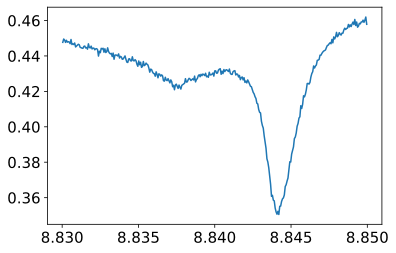

In [72]:
power_idx = 18
print(powers[power_idx])
s11_raw = ys[power_idx] #/ y_bg
f = x

fit_mask = np.ma.masked_inside(f, 8.83, 8.85).mask
plt.plot(f[fit_mask], np.abs(s11_raw)[fit_mask])
plt.show()

In [73]:
f = f[fit_mask]
s11_raw = s11_raw[fit_mask]

 /Users/shoumikdc/crostini/EQuS/abcd_rf_fit/abcd_rf_fit/abcd_rf_fit.py: 224

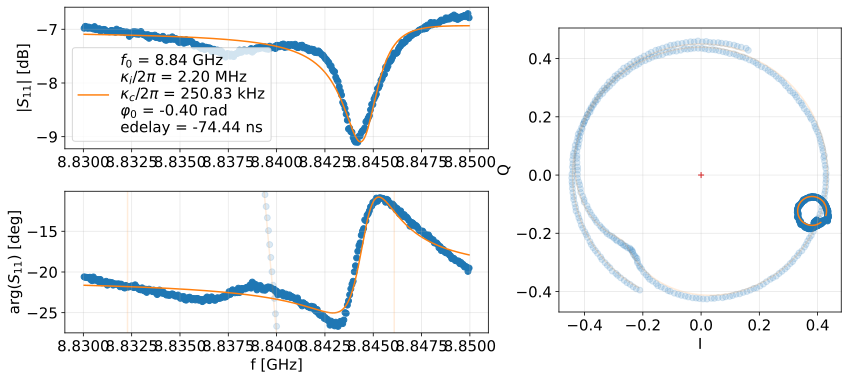

In [74]:
# Initial single Lorenztian fit
fit_func, fit_params = abcd.fit_signal(f * 1e9, s11_raw, 'rm')
fit = fit_func(f * 1e9, *fit_params.tolist())

abcd.plot(f * 1e9, s11_raw, fit, fit_params=fit_params)
plt.show()

In [75]:
def zeros2eps(x):
    eps = np.finfo(float).eps
    y = np.array(x)
    y[np.abs(y) < eps] = eps

    return y

def reflection(freq, f_0, kappa_i, kappa_c, phi_0):

    num = 1j * (freq - f_0) + kappa_i / 2 + kappa_c * (0.5 - np.exp(1j * phi_0))
    den = 1j * (freq - f_0) + (kappa_c + kappa_i) / 2

    return num / zeros2eps(den)

def double_lorentzian(f, f_0, kappa_i, kappa_c, phi_0, amp_g, amp_e, φ, χ):
    """
    Double Lorentzian fit of two reflection dips separated by χ. 
    Here, we assume that the electrical delay has already been removed. 
    """
    return np.exp(1j*φ) * (amp_g * reflection(f, f_0, kappa_i, kappa_c, phi_0) + amp_e * reflection(f, f_0 - χ, kappa_i, kappa_c, phi_0))

In [76]:
s11_edelay = s11_raw * np.exp(-2j * np.pi * fit_params.edelay * f * 1e9)
complex_amp = fit_params.tolist()[-3] + 1j * fit_params.tolist()[-2]
p0_guess = [*fit_params.tolist()[:4],
            np.abs(complex_amp), 
            np.abs(complex_amp), 
            np.angle(complex_amp), 
            7.5e6]
popt_d, _ = abcd.utils.complex_fit(double_lorentzian, f * 1e9, s11_edelay, p0_guess)


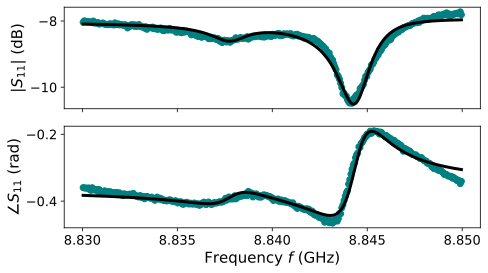

In [115]:
fig, axs = plt.subplots(2, 1, figsize=(7, 4), dpi=300, sharex=True)

font = {'size'   : 13}
mpl.rc('font', **font)

axs[0].plot(f[::1], 10*np.log(np.abs(s11_edelay)[::1]), 'o', c="teal")
axs[0].plot(f, 10*np.log(np.abs(double_lorentzian(f * 1e9, *popt_d))), c="k", lw=3)
axs[0].set_ylabel(r"$|S_{11}|$ (dB)", fontsize=15)

axs[1].plot(f, np.angle(s11_edelay), 'o', c="teal")
axs[1].plot(f, np.angle(double_lorentzian(f * 1e9, *popt_d)), c="k", lw=3)
axs[1].set_ylabel(r"$\angle S_{11}$ (rad)", fontsize=15)

plt.xlabel("Frequency $f$ (GHz)", fontsize=15)
plt.xticks([8.83, 8.835, 8.84, 8.845, 8.85])
plt.tight_layout()
plt.savefig("double_lorentzian_fit.pdf")
plt.show()

## Next Experiment?

## Extracting EL

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import IQ_rotate, IQ_rotate_angle, plot_2D

In [ ]:
directory = 'C:/Users/EQuS/Labber/Data/2023/03/Data_0304/'
# filename = 'two_tone_spec_vs_bobbin_shots_2023-03-04_07-49_0001.hdf5'
filename = 'two_tone_spec_vs_bobbin_shots_2023-03-04_11-56_0001.hdf5'
file = h5py.File(directory + filename, 'r')
data = file['data']
msmt_name = data['msmt_name']
s1 = data['s1'][::]
s2 = data['s2'][::]
fluxes = data['bobbin'][::]
freqs = data['freqs'][::]/1e9


In [ ]:
angle = IQ_rotate_angle(s1[0, :, 0])
s1 = s1*np.exp(1j*angle)
s1 = IQ_rotate(s1)
I1 = np.real(s1)
Q1 = np.imag(s1)

# s2 = IQ_rotate(s2)
s2 = s2*np.exp(1j*angle)
I2 = np.real(s2)
Q2 = np.imag(s2)

I1_ground = I1 < 0.0
I2_ground = I2 < 0.0

p_g = np.zeros((I1.shape[0], I1.shape[2]))
for fdx in range(I1.shape[0]):
    for ddx in range(I1.shape[2]):
        I2_ground_post_selected = I2_ground[fdx, :, ddx][I1_ground[fdx, :, ddx]]
        p_g[fdx, ddx] = np.sum(I2_ground_post_selected)/len(I2_ground_post_selected)

    if 0: 
        H, I_edges, Q_edges = np.histogram2d(I2[fdx, :, ddx], Q2[fdx, :, ddx], bins=100)
        # plt.figure()
        max_coord = np.max([np.max(I2), np.max(Q2)])
        
        # plt.imshow(np.log10(H), extent=[-max_coord, max_coord, -max_coord, max_coord], aspect="equal", interpolation="none")
        plt.figure(figsize = (3,3))
        plt.imshow(H.transpose(), extent=[-max_coord, max_coord, -max_coord, max_coord], aspect="equal", interpolation="none")
        plt.xlabel("I")
        plt.ylabel("Q")
        plt.title(msmt_name)
        plt.tight_layout()
        plt.show()

In [ ]:
p_g_sub_bg = p_g - np.mean(p_g, axis = 1)[:, np.newaxis]
zero_flux = 0.326 # This is actually one flux
half_flux = -0.04465 # This is actually half flux
flux_0 = 2*(zero_flux - half_flux)
flux_plot = (fluxes[::] - zero_flux+flux_0)/flux_0

import matplotlib
font = {'size'   : 14}

matplotlib.rc('font', **font)

drive_freqs = freqs*1e3
fluxes = data['bobbin']
fig = plt.figure(figsize=(6, 4), dpi = 400)
plt.imshow(p_g_sub_bg.T[::-1], extent = [np.min(flux_plot), np.max(flux_plot), np.min(drive_freqs), np.max(drive_freqs)], aspect="auto", interpolation="none", cmap = "Purples")

E_L = 325
print('EL is (MHz)', E_L)
print('crossing at zero flux is at (GHz)', 4*np.pi**2*E_L*0.5/1000)
plt.plot(flux_plot, +4*np.pi**2*E_L*(flux_plot - 0.5))
plt.plot(flux_plot, -4*np.pi**2*E_L*(flux_plot - 0.5))

plt.xlabel(r"$\Phi/\Phi_0$", fontsize = 20, )
plt.ylabel(r"$f_d$ (MHz)", fontsize = 20, )
# plt.xticks([0.49, 0.50, 0.51])
# plt.yticks([50, 150, 250])
plt.ylim(0, 500)
cb = plt.colorbar()
cb.set_label(label = r"$P_e$", fontsize = 20, rotation = -90, labelpad = 0)
cb.ax.set_ylim(0.0, 0.3)
cb.ax.set_yticks([0.0, 0.3])
plt.tight_layout()
plt.show()
# fig.savefig('C:/Users/EQuS/Labber/Data/2023/03/Data_0304/'+'two_tone_spec_vs_bobbin_shots_2023-03-04_07-49_0001_prob_g.png', transparent = True, dpi = 400)
